In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import os

In [2]:
path = 'E:\\Data_Science\\OpenClassRoom\\Projet 5\\archive\\'
cust_df=pd.read_csv(path + 'olist_customers_dataset.csv')
geo_df=pd.read_csv(path +'olist_geolocation_dataset.csv')
ord_it_df=pd.read_csv(path + 'olist_order_items_dataset.csv')
ord_pay_df=pd.read_csv(path + 'olist_order_payments_dataset.csv')
ord_rev_df=pd.read_csv(path + 'olist_order_reviews_dataset.csv')
ord_df=pd.read_csv(path + 'olist_orders_dataset.csv')
prod_df=pd.read_csv(path + 'olist_products_dataset.csv')
sell_df=pd.read_csv(path + 'olist_sellers_dataset.csv')

In [3]:
dfs = {0:cust_df,1:geo_df,2:ord_it_df,3:ord_pay_df,4:ord_rev_df,5:ord_df,6:prod_df,7:sell_df}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-n

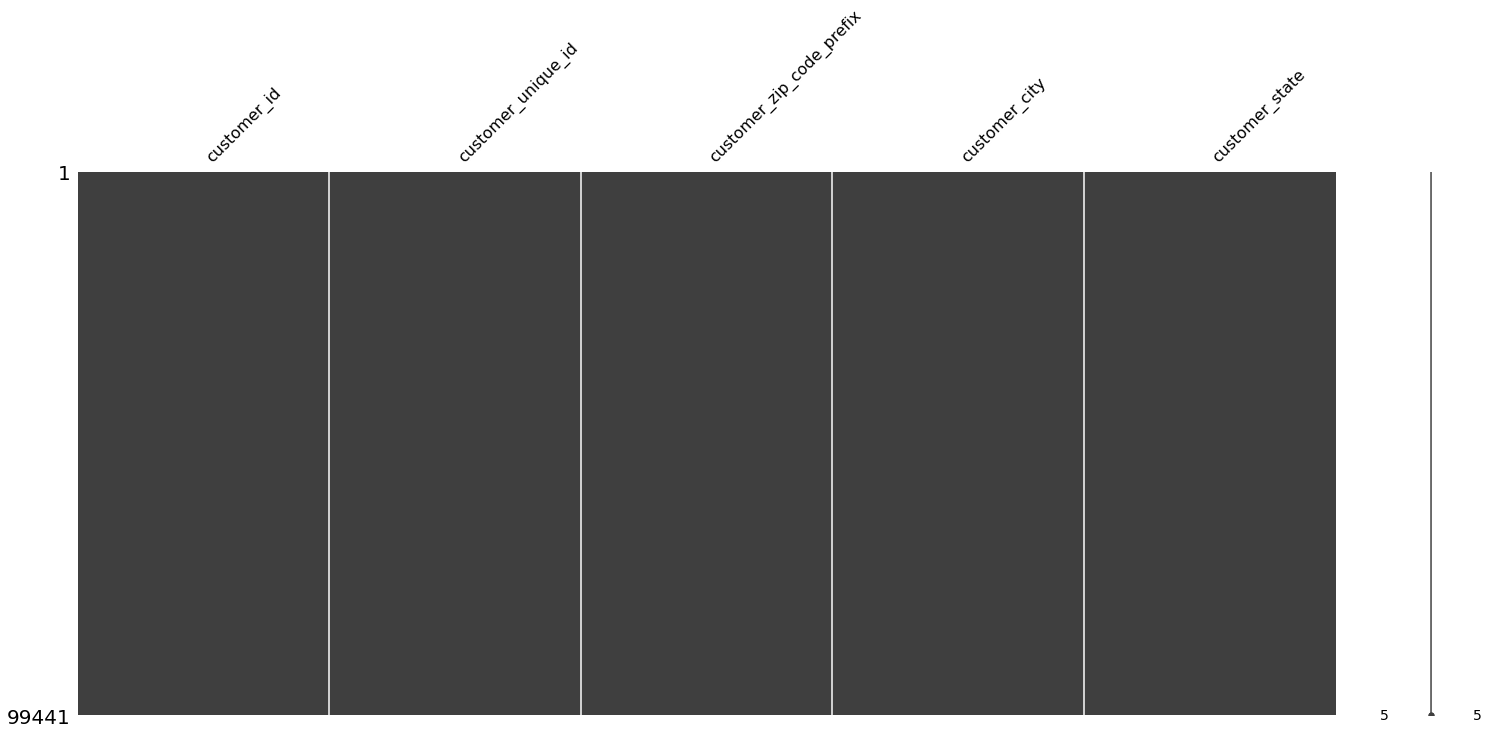

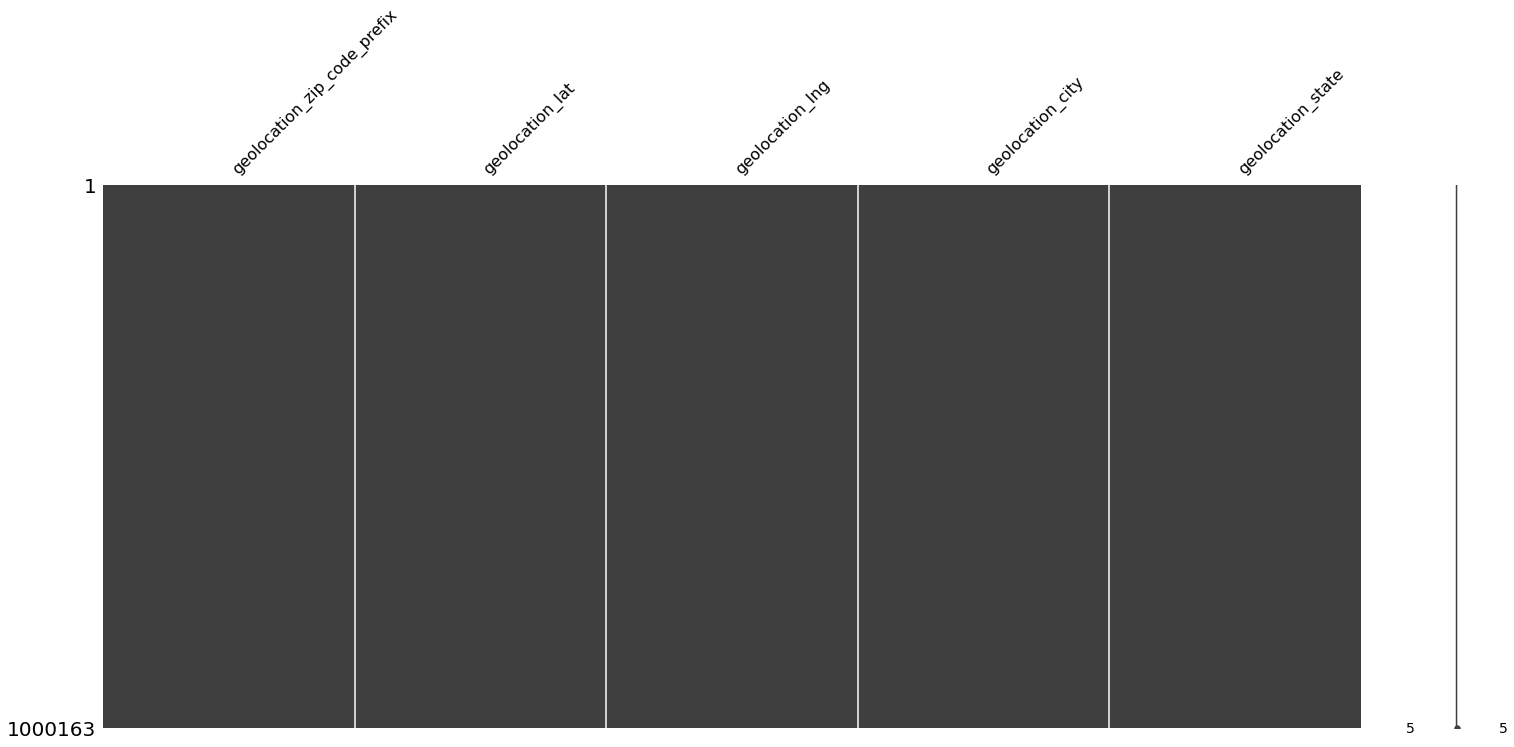

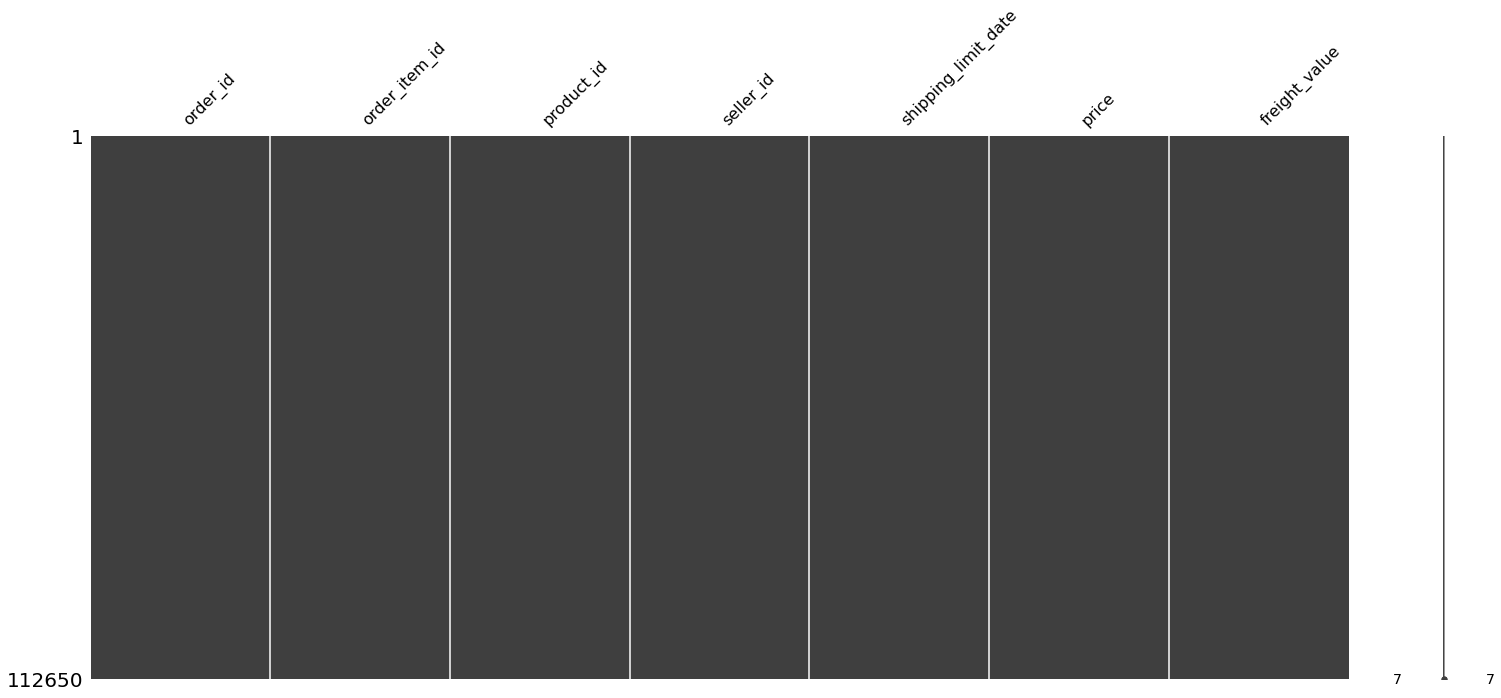

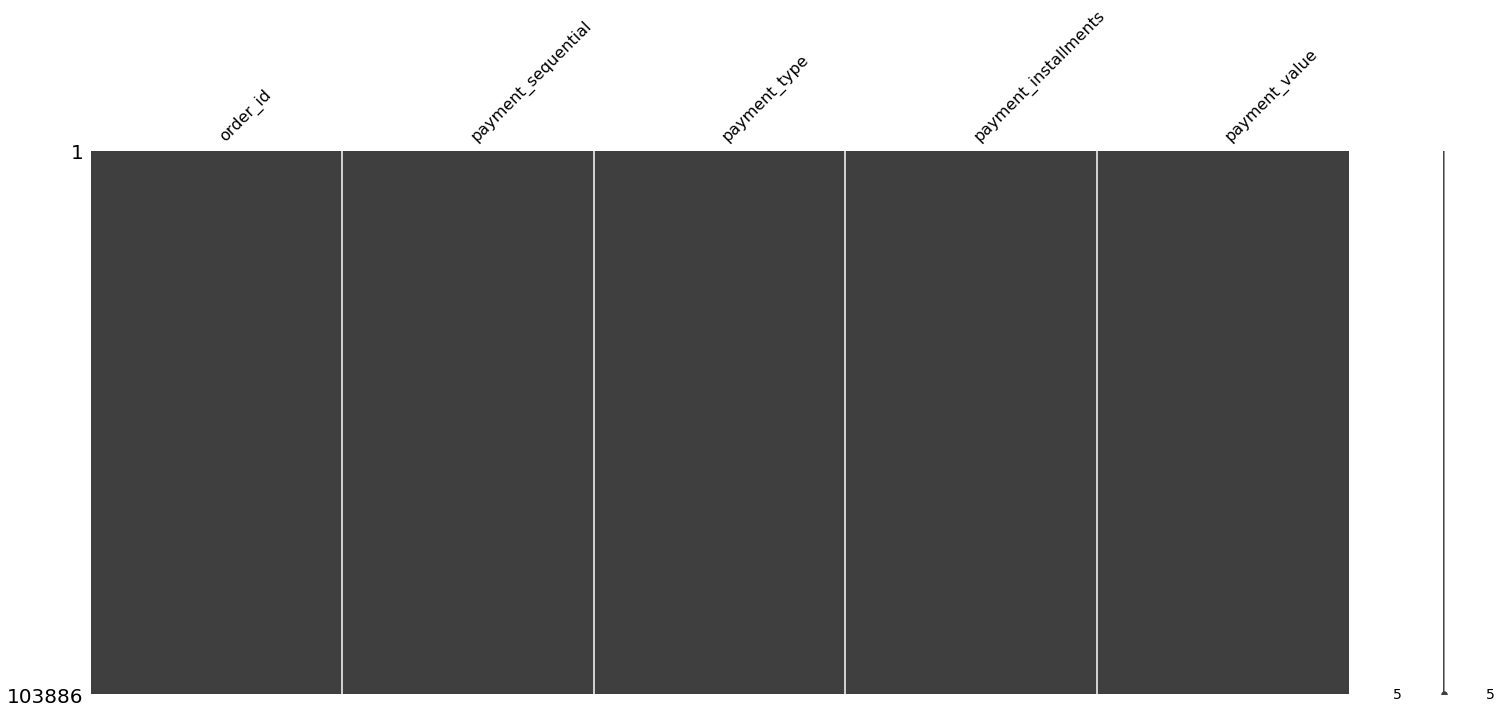

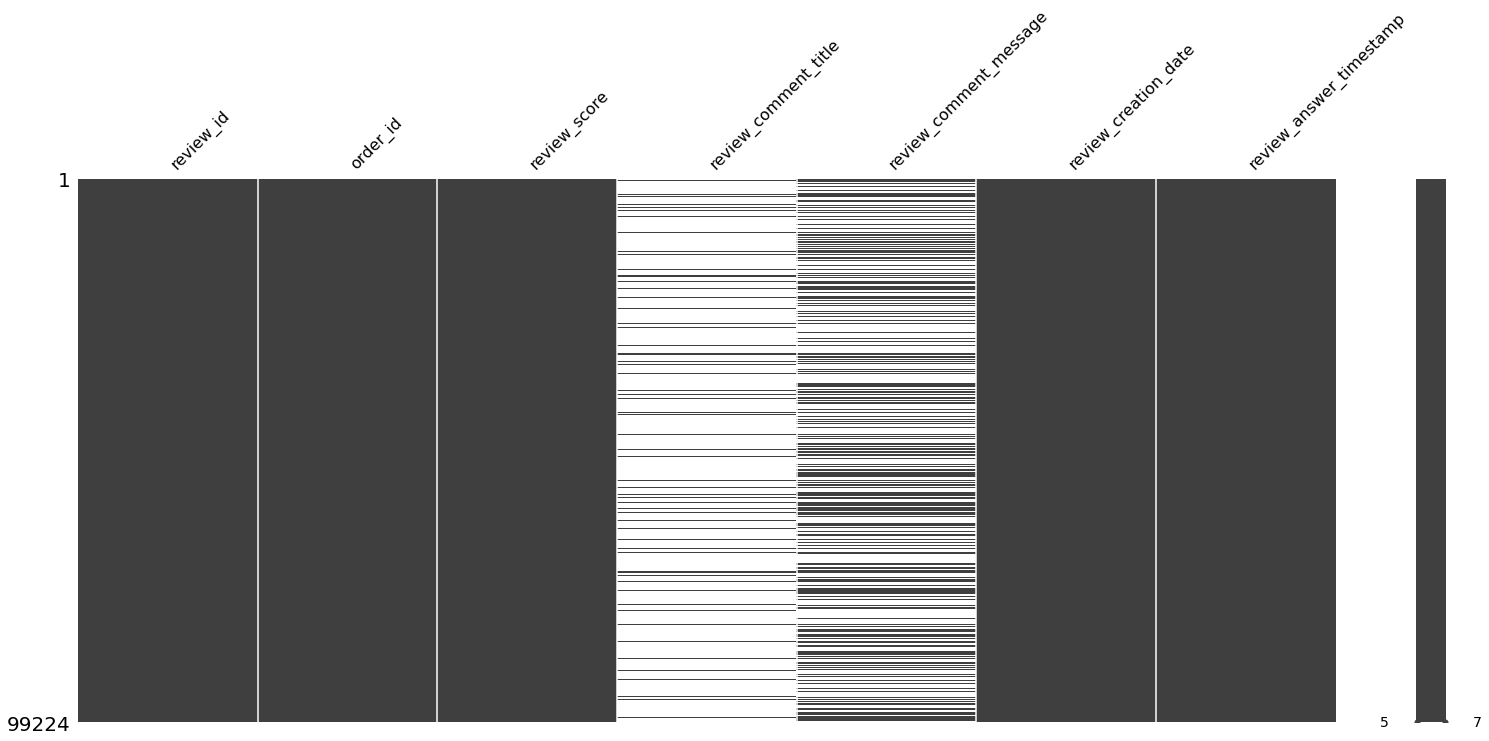

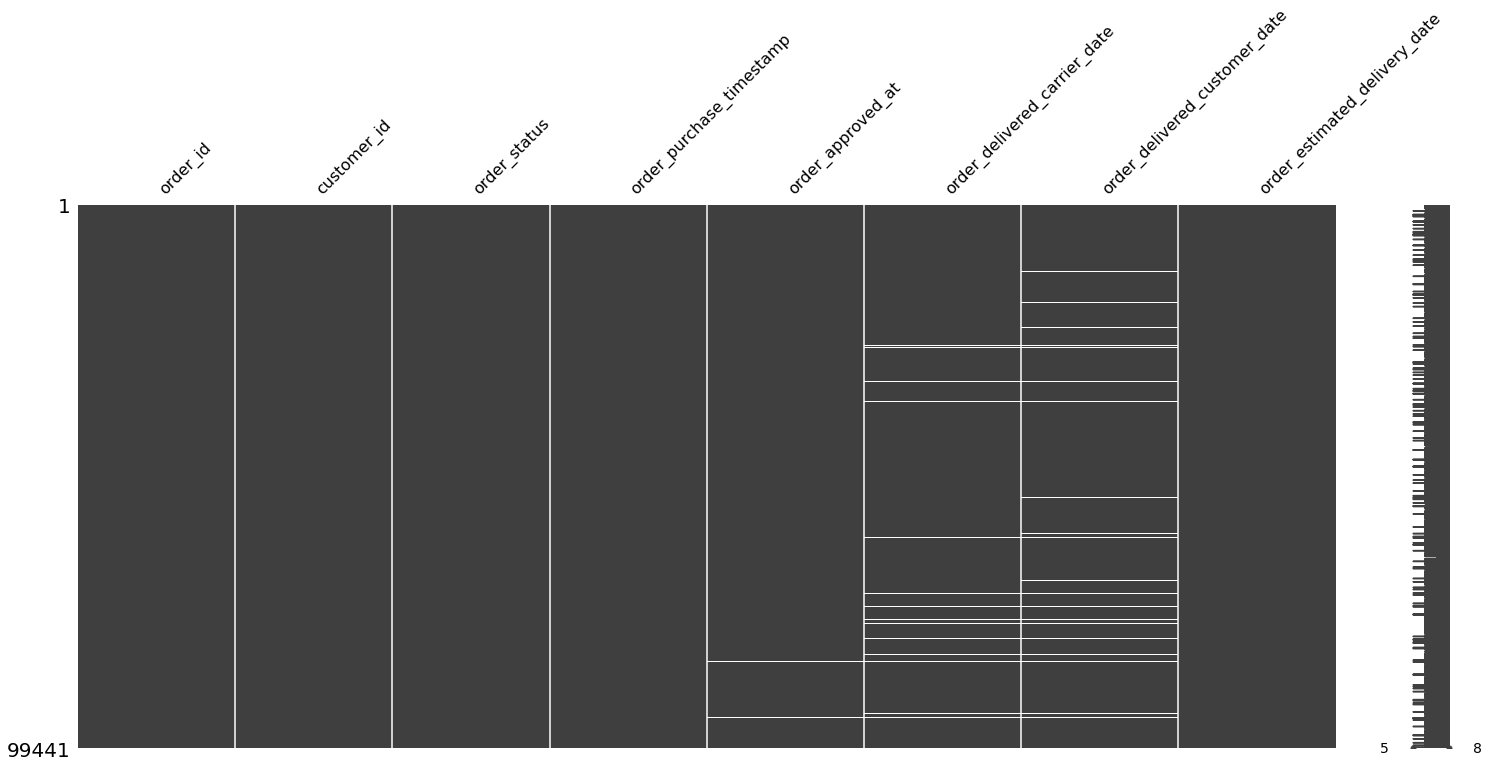

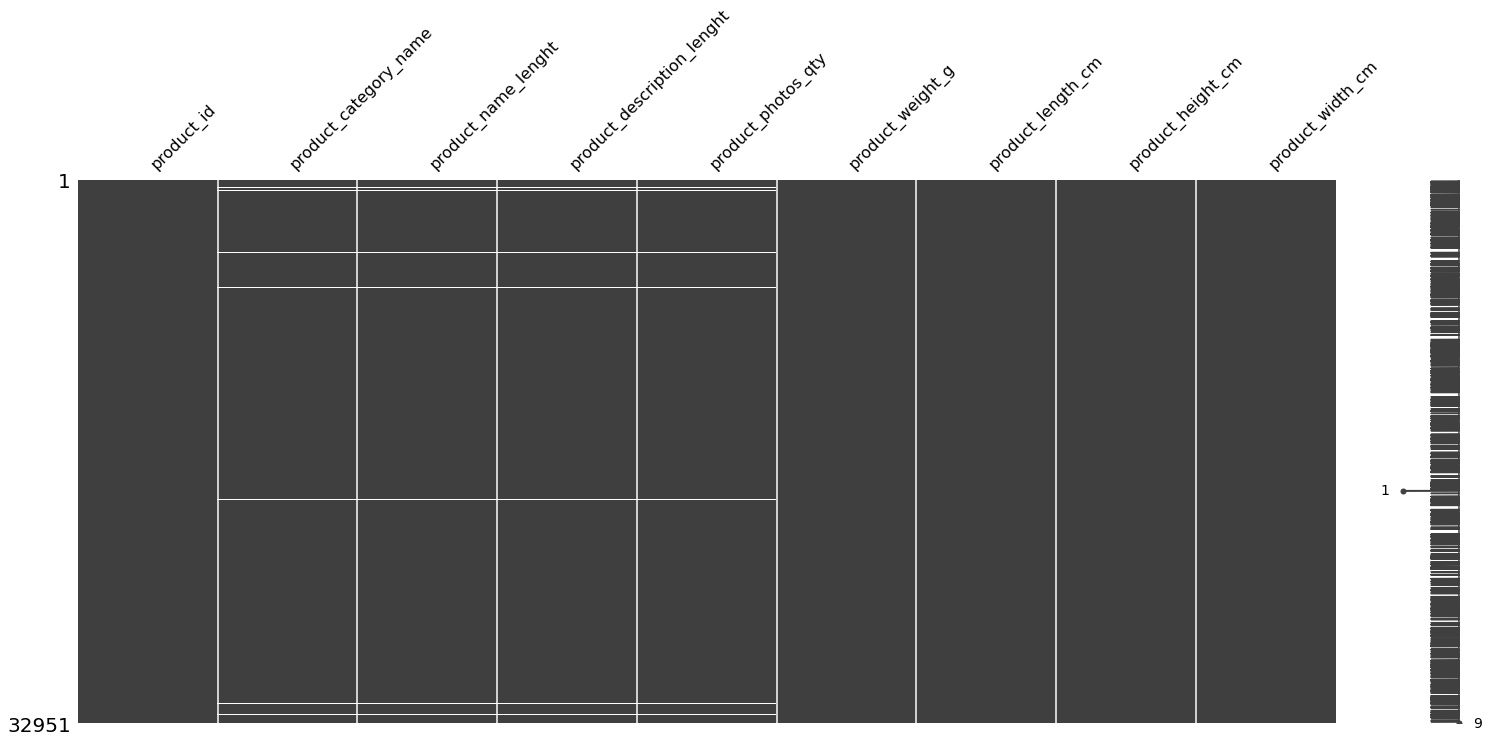

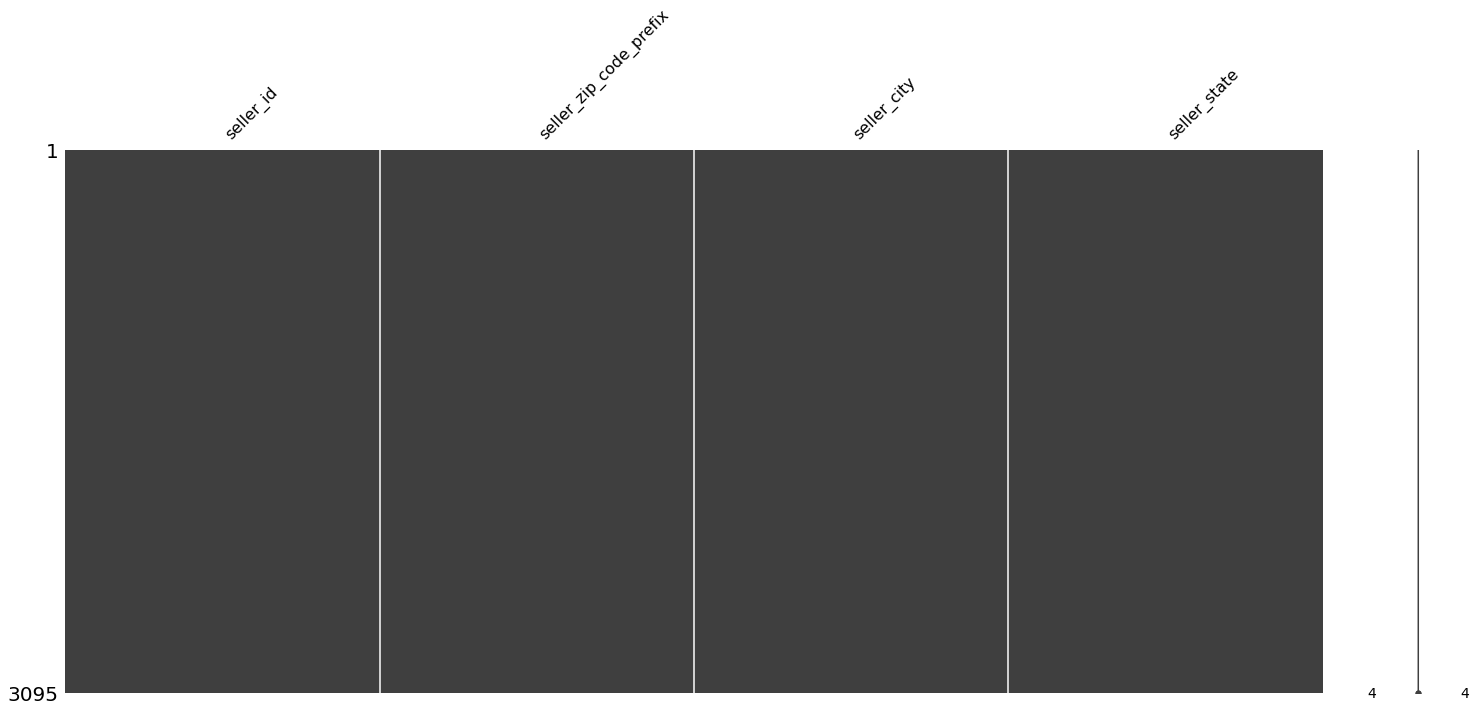

In [4]:
for i in dfs:
    print(dfs[i].info())
    msno.matrix(dfs[i])

In [5]:
#get the customers that ordered more than once
multi_cust_df = dfs[0][dfs[0].groupby('customer_unique_id').customer_unique_id.transform('count') > 1]

#get their customer_id
multi_custom = multi_cust_df[['customer_id','customer_unique_id']]
multi_id = multi_custom['customer_id']
multi_uni_id = multi_custom['customer_unique_id']
#get their order_id
multi_order_df = dfs[5][dfs[5]['customer_id'].isin(multi_id)]
multi_order_id = multi_order_df['order_id']

multi_pay_df = dfs[3][dfs[3]['order_id'].isin(multi_order_id)]



In [6]:
print(dfs[0]['customer_id'].unique().shape[0])
print(dfs[0]['customer_unique_id'].unique().shape[0])

99441
96096


In [7]:
import time
import datetime

def days(x):
    td = time.time()
    t = time.mktime(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S").timetuple())
    d = int((td - t)/86400)
    return d

In [8]:
#build the working df
df = pd.DataFrame(multi_custom)
df = df.set_index('customer_id')
df = df.join(multi_order_df[['customer_id','order_id', 'order_purchase_timestamp']].set_index('customer_id'))
temp = pd.DataFrame()
temp['order_total'] = multi_pay_df.groupby('order_id').payment_value.sum()
df = df.join(temp, on = 'order_id')
df['days_since_order'] = df['order_purchase_timestamp'].apply(days)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 6342 entries, 879864dab9bc3047522c92c82e1212b8 to d9110683c7a282144e9fc97660026a28
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        6342 non-null   object 
 1   order_id                  6342 non-null   object 
 2   order_purchase_timestamp  6342 non-null   object 
 3   order_total               6342 non-null   float64
 4   days_since_order          6342 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 555.3+ KB
None


In [9]:
#build the model df
md_df = pd.DataFrame(index = df['customer_unique_id'].unique())
md_df['n_order'] = df.groupby('customer_unique_id').order_id.count()
md_df['payment_total'] = df.groupby('customer_unique_id').order_total.agg('sum')
md_df['days_since_last_order'] = df.groupby('customer_unique_id').days_since_order.agg('min')

print(md_df.info(),md_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 4c93744516667ad3b8f1fb645a3116a4 to da29b8a3970adddb9ed2dc8a492065af
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   n_order                2997 non-null   int64  
 1   payment_total          2997 non-null   float64
 2   days_since_last_order  2997 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 93.7+ KB
None                                   n_order  payment_total  \
4c93744516667ad3b8f1fb645a3116a4        2         565.88   
1175e95fb47ddff9de6b2b06188f7e0d        2          83.19   
295c05e81917928d76245e842748184d        2         281.50   
e9dd12dca17352644a959d9dea133935        2         113.83   
e079b18794454de9d2be5c12b4392294        2         437.78   

                                  days_since_last_order  
4c93744516667ad3b8f1fb645a3116a4                   1860  
1175e95fb47ddff9de6b2b06188f7e0d              

<AxesSubplot:>

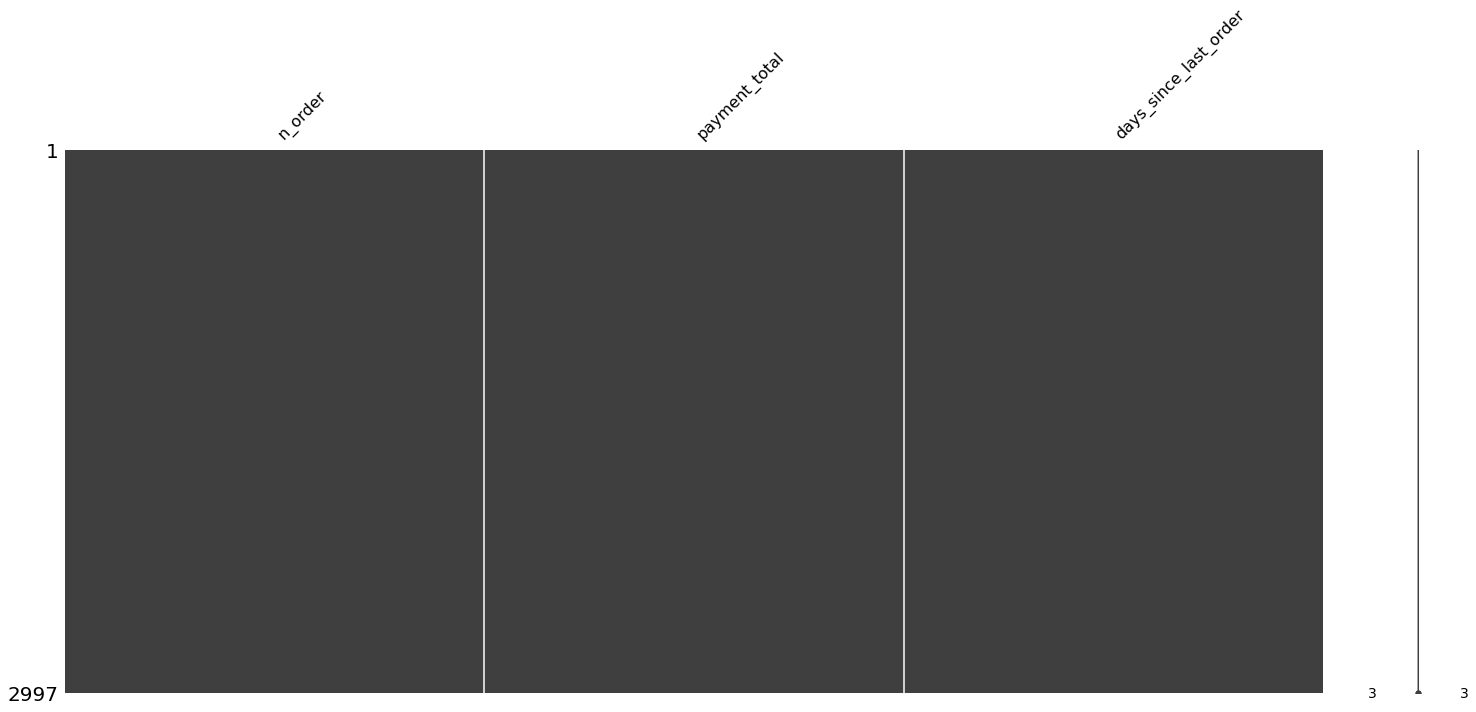

In [10]:
msno.matrix(md_df)

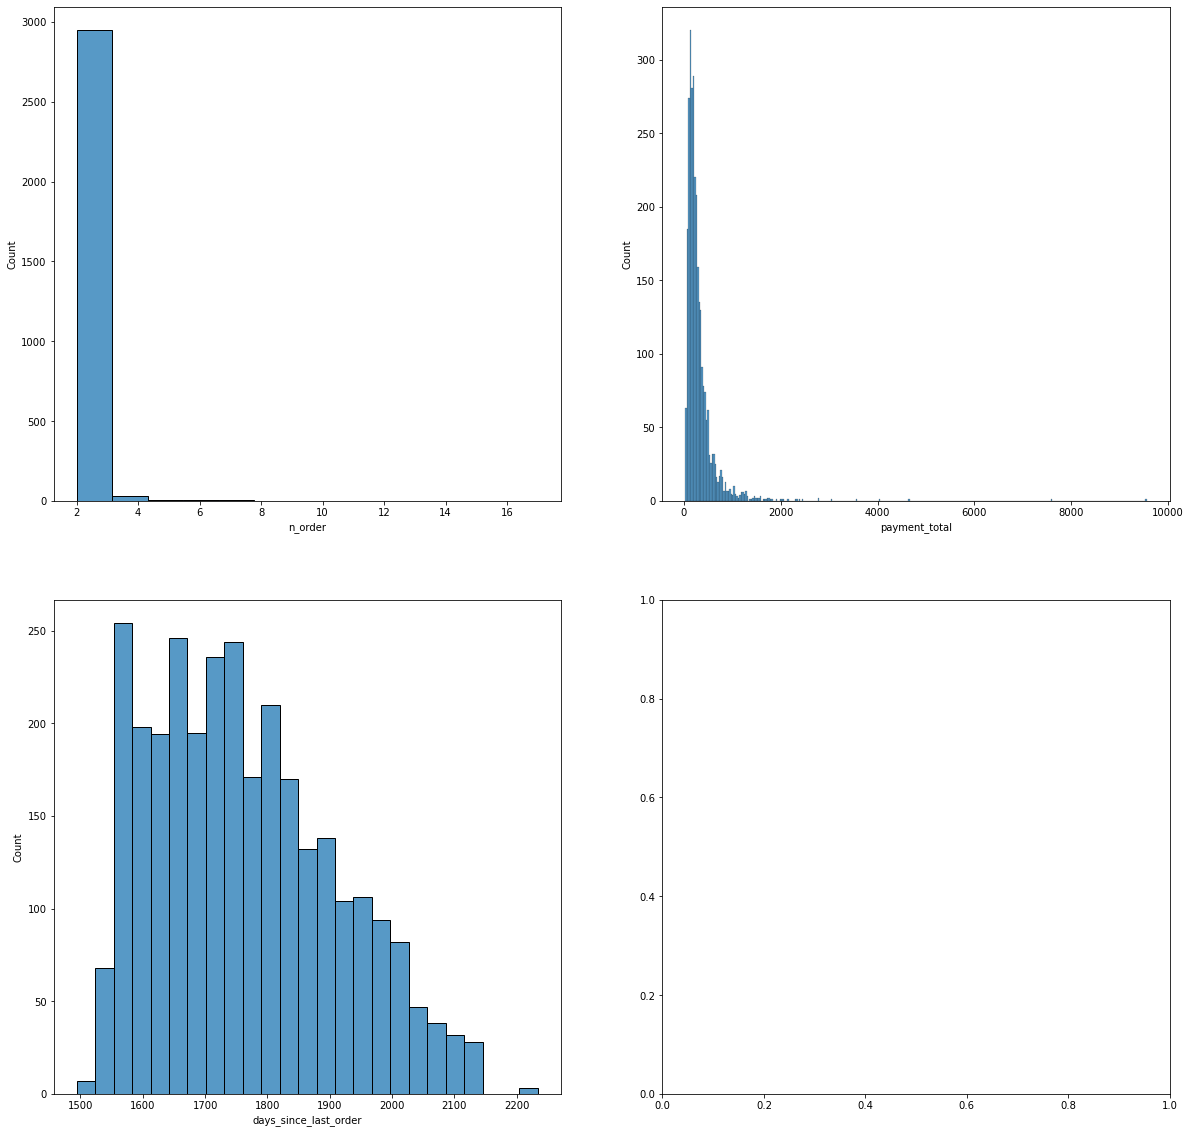

In [11]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
sns.histplot(md_df.iloc[:,0], ax = ax[0,0])
sns.histplot(x=md_df.iloc[:,1], ax = ax[0,1])
sns.histplot(x=md_df.iloc[:,2], ax = ax[1,0])
plt.show()

In [12]:
md_df.to_csv('md_df.csv', index = False)

In [13]:
from mpl_toolkits.mplot3d import Axes3D

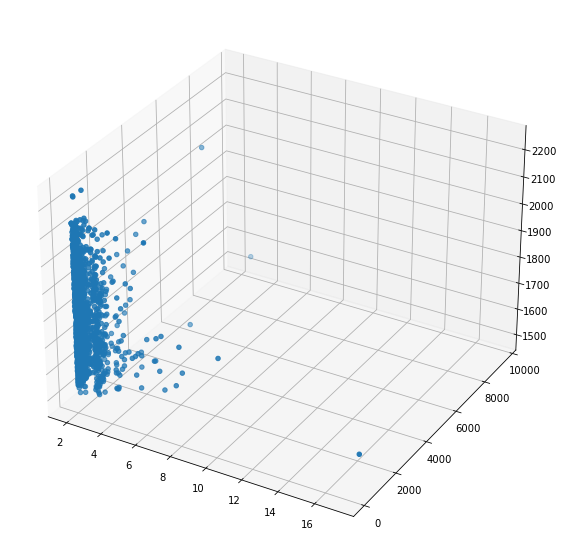

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(md_df.iloc[:,0],md_df.iloc[:,1],md_df.iloc[:,2])

## Dimention reduction

In [15]:
dim_df = pd.read_csv('md_df.csv')
x = dim_df.values
features = dim_df.columns

In [16]:
x[:,1] = np.log(x[:,1])
x[:,0] = np.log(x[:,0])

In [17]:
dim_df.isna().sum()

n_order                  0
payment_total            0
days_since_last_order    0
dtype: int64

In [18]:
from sklearn import decomposition
from sklearn import preprocessing

pca = decomposition.PCA(n_components = 2)
scaler = preprocessing.StandardScaler()
x_scale = preprocessing.scale(x)

pca.fit(x_scale)

PCA(n_components=2)

In [19]:
pca.fit(x_scale)

PCA(n_components=2)

In [20]:
scree = (pca.explained_variance_ratio_*100).round(2).cumsum()
print(scree)

[42.19 74.4 ]


In [21]:
pd.DataFrame(pca.components_, columns = features, index = ['F1', 'F2'])



,n_order,payment_total,days_since_last_order
F1,0.658665,0.671638,-0.339209
F2,0.284915,0.194619,0.938588


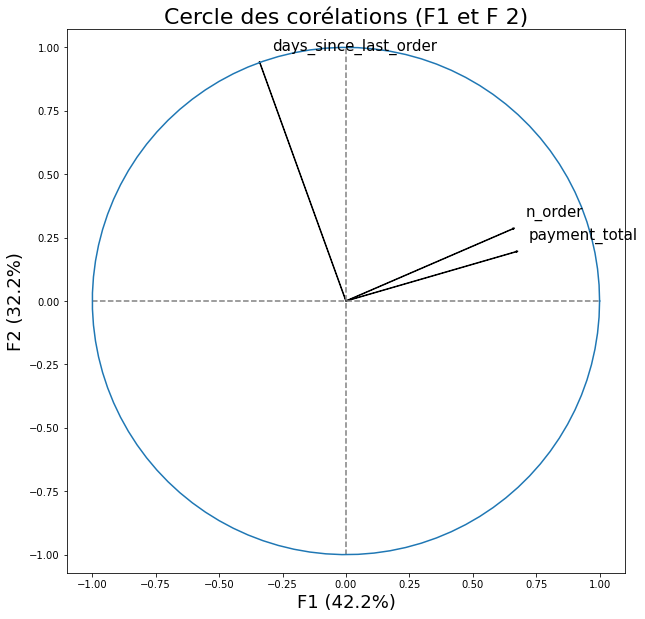

<Figure size 432x288 with 0 Axes>

In [22]:
x, y = 0,1 #define factorial space, (0,1) define the first factorial plane (F1, F2), (2,3) define the second (F3,F4) and so on(tuple)

fig, ax = plt.subplots(figsize = (10,10))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,0, #start the arrow at the origin
                    pca.components_[0,i], #coordinate for PC1
                    pca.components_[1,i], #coordinate for PC2
                    head_width = 0.007,
                    head_length = 0.007,
                    width=0.002,) #graphical aspect of the arrow
    plt.text(pca.components_[0,i] + 0.05,
                        pca.components_[1,i] + 0.05,
                        features[i], fontsize = 15) # plot the text near each arrow head
plt.plot([-1,1], [0,0], color = 'grey', ls='--')
plt.plot([0,0], [-1,1], color='grey', ls='--') #plot the lines (abscissa and ordonate)

plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)), fontsize = 18) #label the axis with the percentage of explained variance
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)),fontsize = 18)

plt.title('Cercle des corélations (F{} et F {})'.format(x+1, y+1), fontsize = 22)

an = np.linspace(0, 2 * np.pi, 100) #return an np.array of the coordinates (100) of a circle of circonference 1 (2*pi)
plt.plot(np.cos(an), np.sin(an)) #plot the circle
plt.axis('equal') #set equal scaling
plt.show()
plt.clf()

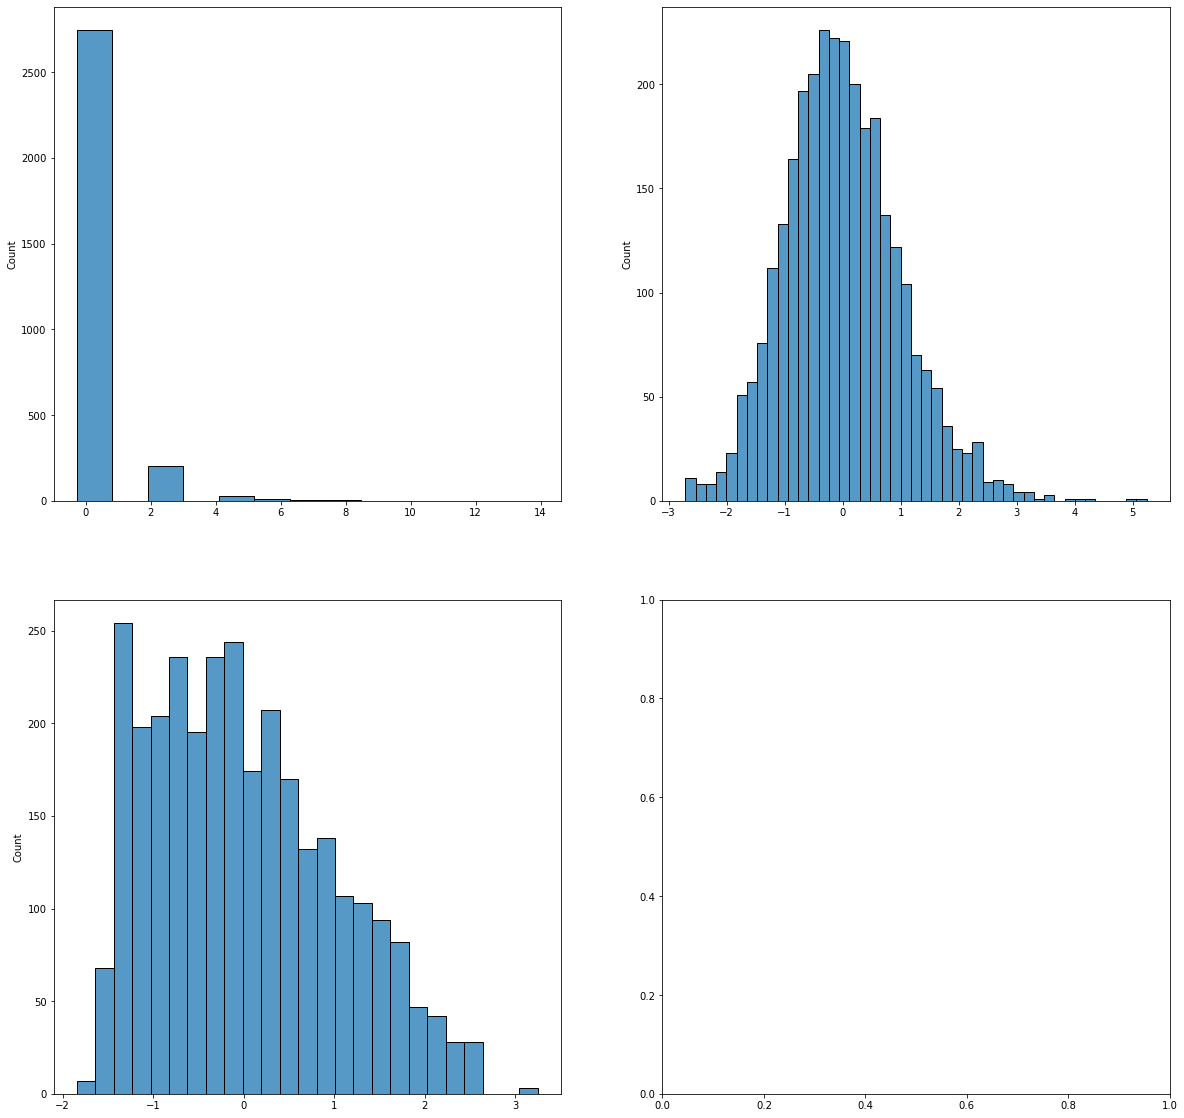

In [23]:
fig,ax = plt.subplots(2,2, figsize=(20,20))
sns.histplot(x_scale[:,0], ax = ax[0,0])
sns.histplot(x_scale[:,1], ax = ax[0,1])
sns.histplot(x_scale[:,2], ax = ax[1,0])
plt.show()

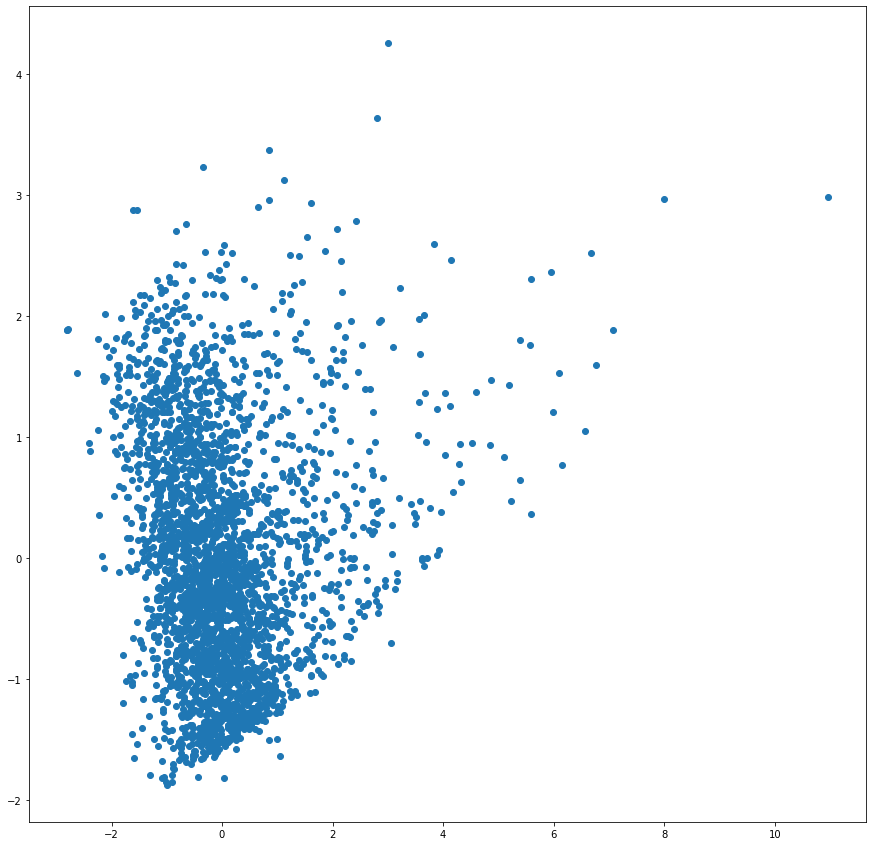

In [24]:
x_proj = pd.DataFrame(pca.transform(x_scale))
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(x_proj.iloc[:,0],x_proj.iloc[:,1])
plt.show()

In [25]:
from sklearn import cluster, metrics

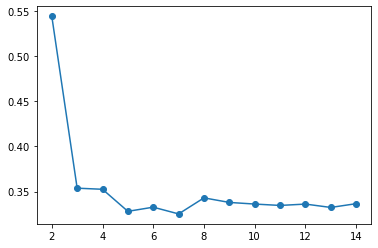

In [26]:
silhouette = []
for i in range(2,15):
    clus = cluster.KMeans(n_clusters = i)
    clus.fit(x_scale)
    sil  = metrics.silhouette_score(x_scale, clus.labels_)
    silhouette.append(sil)
    
plt.plot(range(2,15), silhouette, marker ='o')


In [36]:
from sklearn.manifold import Isomap
iso = Isomap()
from sklearn.manifold import MDS
mds = MDS()
from sklearn.manifold import TSNE
tsne = TSNE()

x_proj2 = mds.fit_transform(x_scale)
x_proj3 = tsne.fit_transform(x_scale)
x_proj4 = iso.fit_transform(x_scale)

E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\manifold\_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
E:\Data_Science\Anaconda\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


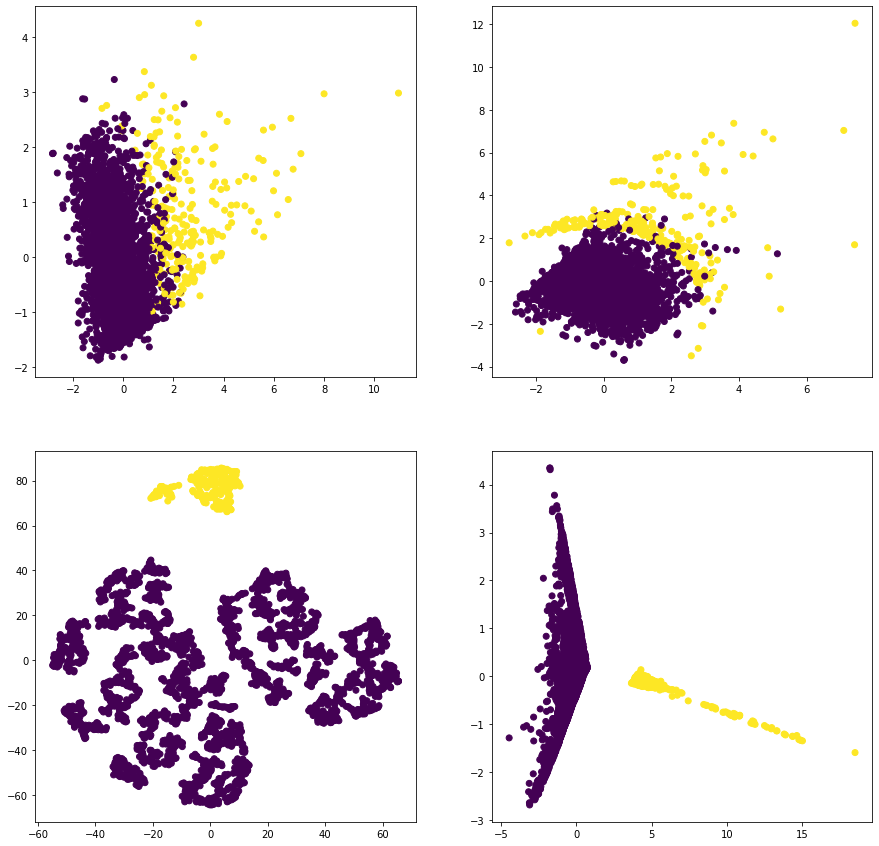

In [34]:
clus = cluster.KMeans(n_clusters = 2)
clus.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=clus.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=clus.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=clus.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=clus.labels_)
plt.show()

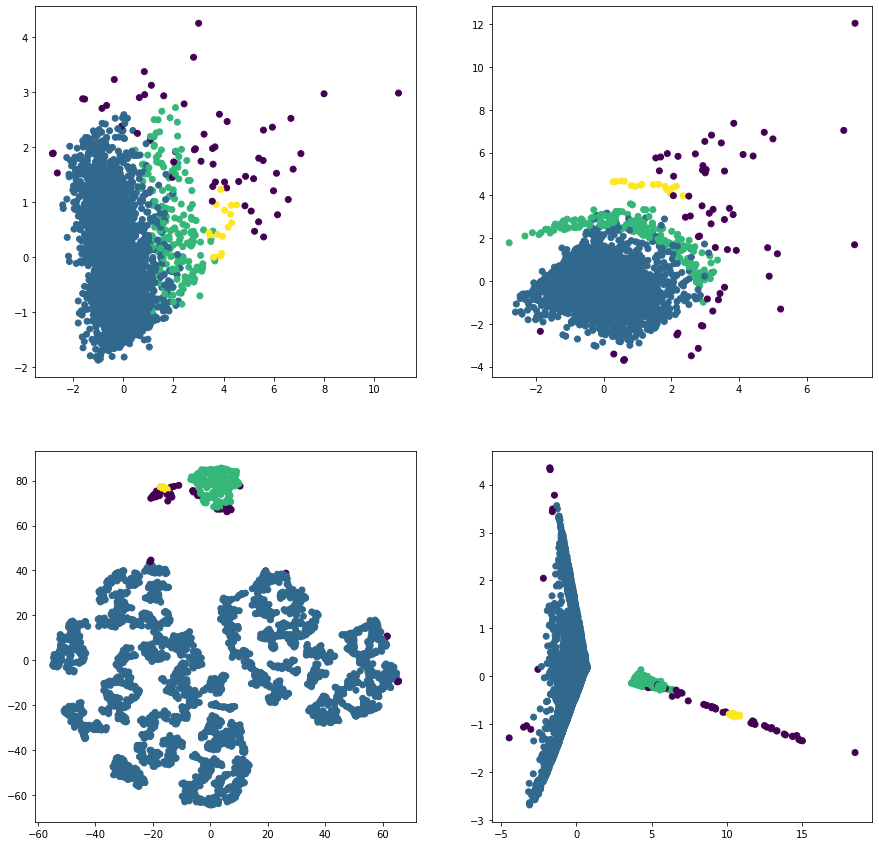

In [35]:
dbscan = cluster.DBSCAN()
dbscan.fit(x_scale)

fig,ax =plt.subplots(2,2,figsize = (15,15))
ax[0,0].scatter(x_proj[:,0], x_proj[:,1], c=dbscan.labels_)
ax[0,1].scatter(x_proj2[:,0], x_proj2[:,1], c=dbscan.labels_)
ax[1,0].scatter(x_proj3[:,0], x_proj3[:,1], c=dbscan.labels_)
ax[1,1].scatter(x_proj4[:,0], x_proj4[:,1], c=dbscan.labels_)
plt.show()

In [38]:
md_df['clus_label'] = clus.labels_
md_df['dbscan_label'] = dbscan.labels_

In [49]:
md_df.loc[md_df['clus_label'] == 0].describe()


,n_order,payment_total,days_since_last_order,clus_label,dbscan_label
count,2745.0,2745.000000,2745.000000,2745.0,2745.000000
mean,2.0,294.847137,1763.928233,0.0,-0.004372
std,0.0,310.148776,144.679908,0.0,0.065985
min,2.0,34.970000,1494.000000,0.0,-1.000000
25%,2.0,142.460000,1648.000000,0.0,0.000000
50%,2.0,217.740000,1745.000000,0.0,0.000000
75%,2.0,344.090000,1862.000000,0.0,0.000000
max,2.0,7571.630000,2234.000000,0.0,0.000000


In [48]:
md_df.loc[md_df['clus_label'] == 1].describe()

,n_order,payment_total,days_since_last_order,clus_label,dbscan_label
count,252.000000,252.000000,252.000000,252.0,252.000000
mean,3.380952,534.394127,1739.174603,1.0,0.682540
std,1.196656,725.328023,150.938687,0.0,0.852938
min,3.000000,46.860000,1507.000000,1.0,-1.000000
25%,3.000000,242.422500,1621.750000,1.0,1.000000
50%,3.000000,380.380000,1702.000000,1.0,1.000000
75%,3.000000,636.827500,1846.500000,1.0,1.000000
max,17.000000,9553.020000,2143.000000,1.0,2.000000


In [57]:
temp = np.unique(dbscan.labels_)
for i in temp:
    print(i, md_df.loc[md_df['dbscan_label'] == i].describe())

-1          n_order  payment_total  days_since_last_order  clus_label  \
count  60.000000      60.000000              60.000000   60.000000   
mean    4.133333    1173.624167            1866.316667    0.800000   
std     2.310379    1707.119115             213.757941    0.403376   
min     2.000000      38.240000            1549.000000    0.000000   
25%     3.000000     199.675000            1692.500000    1.000000   
50%     4.000000     664.030000            1849.500000    1.000000   
75%     5.000000    1205.612500            2071.000000    1.000000   
max    17.000000    9553.020000            2234.000000    1.000000   

       dbscan_label  
count          60.0  
mean           -1.0  
std             0.0  
min            -1.0  
25%            -1.0  
50%            -1.0  
75%            -1.0  
max            -1.0  
0        n_order  payment_total  days_since_last_order  clus_label  dbscan_label
count   2733.0    2733.000000            2733.000000      2733.0        2733.0
mean    